<a href="https://colab.research.google.com/github/Rmostert/image-classification/blob/main/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, we'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content





First up is importing the packages we'll need. It's good practice to keep all the imports at the beginning of your code.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torch import optim
from torch import nn
from collections import OrderedDict
import numpy as np
import json
from PIL import Image
import scipy.io as sio
import os
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


Let's load our data and do the necessary transformations

In [4]:
os.chdir('/content/drive')

In [5]:
means = [0.485, 0.456, 0.406]
stdevs = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=means, std=stdevs)])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=means, std=stdevs)])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=means, std=stdevs)])

train_datasets = datasets.Flowers102(root='MyDrive/',split='test',download=True,transform=train_transforms) # The test and train sets will be switched, since there are much more images in the test set
valid_datasets = datasets.Flowers102(root='MyDrive/',split='val',download=True,transform=validation_transforms)
test_datasets = datasets.Flowers102(root='MyDrive/',split='train',download=True,transform=test_transforms)


trainloader = torch.utils.data.DataLoader(dataset=train_datasets,batch_size=32,shuffle=True)
validloader = torch.utils.data.DataLoader(dataset=valid_datasets,batch_size=32)
testloader = torch.utils.data.DataLoader(dataset=test_datasets,batch_size=32,shuffle=True)


In [ ]:
#Calculate the number of categories

In [11]:
labels = sio.loadmat('MyDrive/flowers-102/imagelabels.mat')

In [12]:
splits = sio.loadmat('MyDrive/flowers-102/setid.mat')
labels = sio.loadmat('MyDrive/flowers-102/imagelabels.mat')

output_size = len(set(labels['labels'][0]))
training_size = len(splits['tstid'][0])
valid_size = len(splits['valid'][0])
test_size = len(splits['trnid'][0])

In [13]:
print('Number of training images: {}'.format(training_size))
print('Number of validation images: {}'.format(valid_size))
print('Number of test images: {}'.format(test_size))
print('Number of flower categories: {}'.format(output_size))



Number of training images: 6149
Number of validation images: 1020
Number of test images: 1020
Number of flower categories: 102


In [23]:
#View some of the data

def plot_image(images,axes,number_images):

    mean = np.array(means)
    std = np.array(stdevs)


    if number_images == 1:


        image = images[1].numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axes.axis('off')
        axes.imshow(image)



    else:
        plot_shape = axes.shape

        if len(plot_shape) == 1:
            for row in range(plot_shape[0]):

                ax = axes[row]
                image = images[row].numpy().transpose((1, 2, 0))
                image = std * image + mean
                image = np.clip(image, 0, 1)
                ax.axis('off')
                ax.imshow(image)

        else:

            i = 0
            for row in range(plot_shape[0]):
                for col in range(plot_shape[1]):

                    ax = axes[row,col]
                    image = images[i].numpy().transpose((1, 2, 0))
                    image = std * image + mean
                    image = np.clip(image, 0, 1)
                    ax.axis('off')
                    ax.imshow(image)
                    i+=1


def show_image(images,number_images=1):

    ncols= 4
    nrows= int(np.ceil(number_images/4))

    if number_images == 1:
        fig, axes = plt.subplots()
        plot_image(images,axes,number_images)

    else:
        fig, axes = plt.subplots(figsize=(10,4),ncols=min(ncols,number_images),nrows=nrows)
        plot_image(images,axes,number_images)






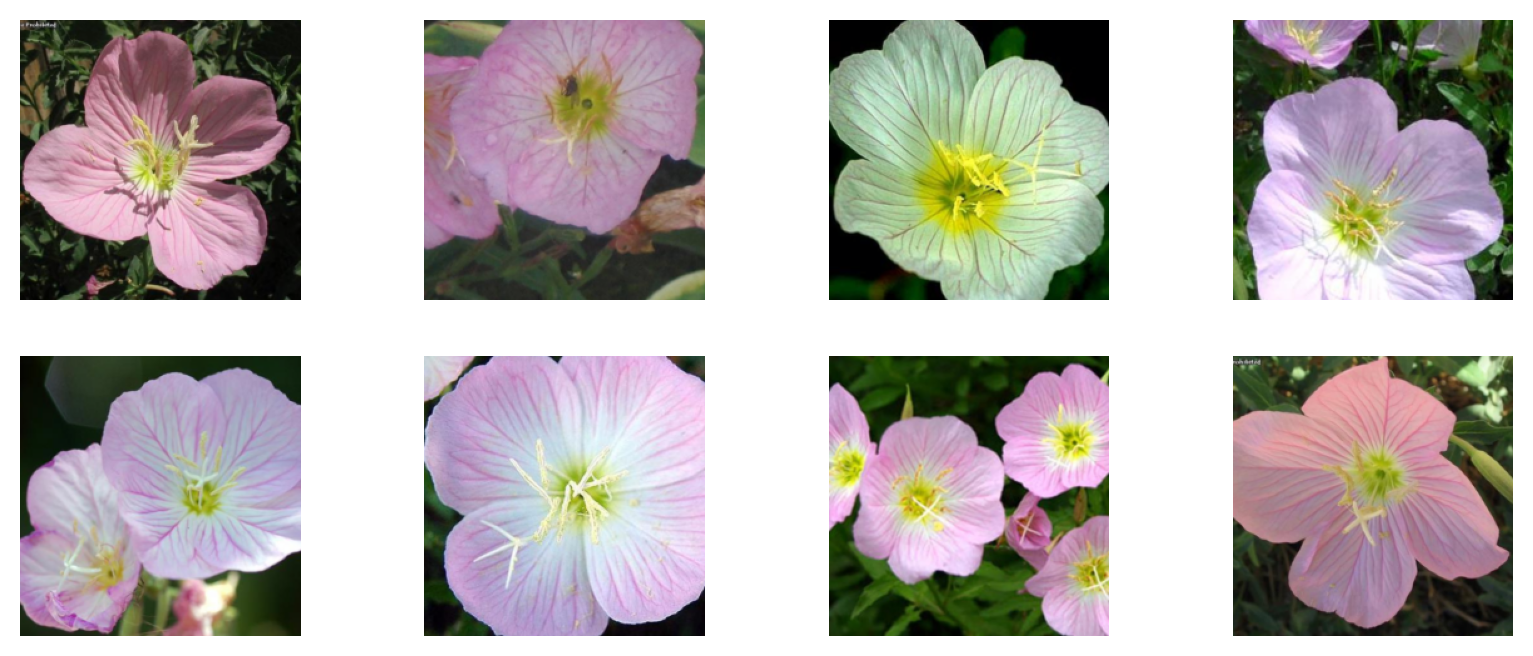

In [20]:
images, labels = next(iter(validloader))
show_image(images,7)

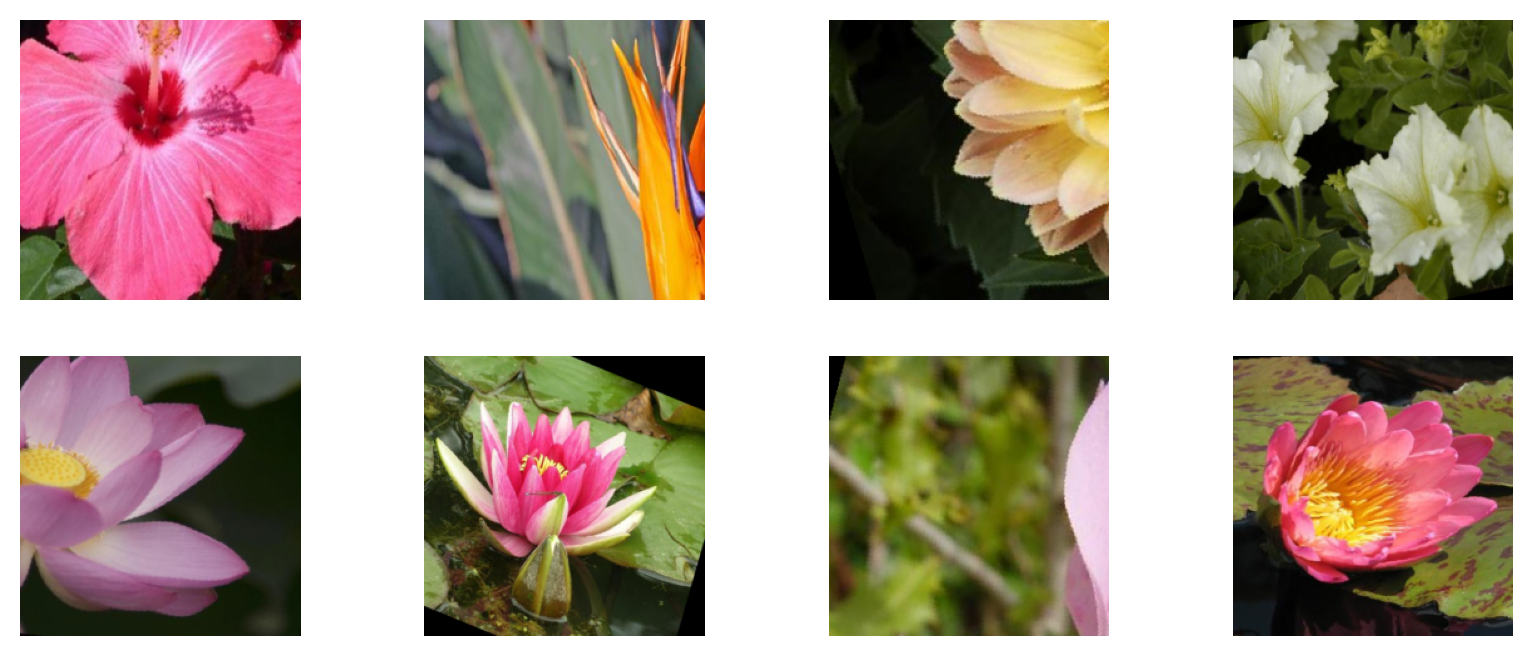

In [21]:
images, labels = next(iter(trainloader))
show_image(images,7)

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('MyDrive/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of the pretrained models from `torchvision.models` to get the image features. Then we'll will build and train a new feed-forward classifier using those features. This is called transfer learning. To quote the following excellent machine learning [source](https://machinelearningmastery.com/transfer-learning-for-deep-learning/):

"Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems."

So we'll need to follow the following steps:

* Load a [pre-trained network](https://docs.pytorch.org/vision/main/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we will only be updating the weights of the feed-forward network.

We'll start by making use of the VGG16 network. We'll use the existing classifier, and only change the output features to reflect the current classification problem

In [24]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.5MB/s]


In [25]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# Build our first model

def initial_model():
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(4096, 1000)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.5)),
                          ('fc3', nn.Linear(1000, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    return model, criterion, optimizer


Now we can initialise our model

In [39]:
model, criterion, optimizer = initial_model()

Next we'll write the following function to calculate the accuracy and loss on the validation/test set

In [18]:
def test_validation_stats(model,dataloader,criterion,device='cpu'):
    loss = 0
    correct = 0
    total = 0

    model.to(device)

    for i, (valid_images, valid_labels) in enumerate(validloader):

        valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
        outputs = model.forward(valid_images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == valid_labels).sum().item()
        total += valid_labels.size(0)
        accuracy = correct/total
        loss += criterion(outputs, valid_labels).item()

    return accuracy,loss




Next we'll write the model training function

In [29]:
def train_model(model, trainloader, optimizer, criterion, epochs=3,print_every=40, device='cpu'):

    model.to(device)
    steps = 0

    for e in range(epochs):
        running_loss = 0

        for i, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:

                model.eval()

                with torch.no_grad():
                    valid_accuracy,valid_loss = test_validation_stats(model,validloader,criterion,device=device)

                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Loss: {:.4f}".format(valid_loss),
                      "Validation Accuracy: {:.2f}".format(valid_accuracy*100))



                running_loss = 0
                model.train()

    return model


Now we're ready to train our first model!

In [40]:
start_time = datetime.now()
train_model(model, trainloader, optimizer, criterion, epochs=6,print_every=40,device=device)
print(f'Runtime: {datetime.now() - start_time}')

Epoch: 1/6...  Training Loss: 4.6658 Validation Loss: 140.6481 Validation Accuracy: 10.78
Epoch: 1/6...  Training Loss: 3.6943 Validation Loss: 118.4325 Validation Accuracy: 21.67
Epoch: 1/6...  Training Loss: 3.2275 Validation Loss: 102.1792 Validation Accuracy: 27.25
Epoch: 1/6...  Training Loss: 2.8574 Validation Loss: 78.3067 Validation Accuracy: 39.02
Epoch: 2/6...  Training Loss: 0.4436 Validation Loss: 72.9882 Validation Accuracy: 41.27
Epoch: 2/6...  Training Loss: 2.5052 Validation Loss: 64.2307 Validation Accuracy: 48.24
Epoch: 2/6...  Training Loss: 2.4083 Validation Loss: 59.7964 Validation Accuracy: 52.84
Epoch: 2/6...  Training Loss: 2.4607 Validation Loss: 51.3359 Validation Accuracy: 57.84
Epoch: 2/6...  Training Loss: 2.2335 Validation Loss: 50.2191 Validation Accuracy: 57.84
Epoch: 3/6...  Training Loss: 0.7951 Validation Loss: 52.4627 Validation Accuracy: 55.39
Epoch: 3/6...  Training Loss: 2.1651 Validation Loss: 47.1258 Validation Accuracy: 61.96
Epoch: 3/6...  Tra

Next, we'll decrease the number of hidden layers and change the number of hidden neurons as follows


In [42]:
num_hidden_neurons = int((25088 + 102)/ 2)
print(num_hidden_neurons)

12595


In [43]:
def second_model(learning_rate):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, num_hidden_neurons)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(num_hidden_neurons, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    return model, criterion, optimizer


model2, criterion, optimizer = second_model(0.001)

In [44]:
start_time = datetime.now()
model2 = train_model(model2, trainloader, optimizer, criterion, epochs=3,print_every=40,device=device)
print(f'Runtime: {datetime.now() - start_time}')

Epoch: 1/3...  Training Loss: 10.6904 Validation Loss: 123.7147 Validation Accuracy: 27.65
Epoch: 1/3...  Training Loss: 2.8015 Validation Loss: 80.8657 Validation Accuracy: 43.43
Epoch: 1/3...  Training Loss: 2.4183 Validation Loss: 64.6139 Validation Accuracy: 53.24
Epoch: 1/3...  Training Loss: 2.3293 Validation Loss: 53.8915 Validation Accuracy: 58.24
Epoch: 2/3...  Training Loss: 0.3278 Validation Loss: 50.5936 Validation Accuracy: 62.94
Epoch: 2/3...  Training Loss: 1.9569 Validation Loss: 41.7875 Validation Accuracy: 65.69
Epoch: 2/3...  Training Loss: 1.7687 Validation Loss: 44.5947 Validation Accuracy: 65.98
Epoch: 2/3...  Training Loss: 1.9561 Validation Loss: 40.1636 Validation Accuracy: 68.73
Epoch: 2/3...  Training Loss: 1.8388 Validation Loss: 37.0133 Validation Accuracy: 72.06
Epoch: 3/3...  Training Loss: 0.6324 Validation Loss: 36.4522 Validation Accuracy: 72.94
Epoch: 3/3...  Training Loss: 1.6891 Validation Loss: 29.7497 Validation Accuracy: 75.39
Epoch: 3/3...  Trai

We can probably increase the number of epoch to 6. Let's continue training

In [45]:
model2 = train_model(model2, trainloader, optimizer, criterion, epochs=3,print_every=40,device=device)

Epoch: 1/3...  Training Loss: 1.3947 Validation Loss: 35.3783 Validation Accuracy: 73.43
Epoch: 1/3...  Training Loss: 1.5849 Validation Loss: 31.4501 Validation Accuracy: 75.00
Epoch: 1/3...  Training Loss: 1.5428 Validation Loss: 25.4922 Validation Accuracy: 78.92
Epoch: 1/3...  Training Loss: 1.5251 Validation Loss: 25.1653 Validation Accuracy: 78.73
Epoch: 2/3...  Training Loss: 0.1972 Validation Loss: 25.9775 Validation Accuracy: 79.61
Epoch: 2/3...  Training Loss: 1.6210 Validation Loss: 30.4487 Validation Accuracy: 77.06
Epoch: 2/3...  Training Loss: 1.4270 Validation Loss: 28.0691 Validation Accuracy: 77.84
Epoch: 2/3...  Training Loss: 1.5032 Validation Loss: 28.1993 Validation Accuracy: 78.73
Epoch: 2/3...  Training Loss: 1.5856 Validation Loss: 25.5925 Validation Accuracy: 78.82
Epoch: 3/3...  Training Loss: 0.5263 Validation Loss: 25.6129 Validation Accuracy: 79.31
Epoch: 3/3...  Training Loss: 1.5074 Validation Loss: 28.4632 Validation Accuracy: 79.22
Epoch: 3/3...  Traini

Not bad at all! Next we'll evaluate the densenet121 pre-trained network. This is a Densely Connected Convolutional Network and details can be found [here](https://arxiv.org/abs/1608.06993)

In [46]:
def third_model(learning_rate):
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(512, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    return model, criterion, optimizer


model3, criterion, optimizer = third_model(0.001)



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 199MB/s]


In [47]:
start_time = datetime.now()
model3 = train_model(model3, trainloader, optimizer, criterion, epochs=3,print_every=40,device=device)
print(f'Runtime: {datetime.now() - start_time}')

Epoch: 1/3...  Training Loss: 4.3611 Validation Loss: 141.3661 Validation Accuracy: 7.65
Epoch: 1/3...  Training Loss: 3.7209 Validation Loss: 124.9350 Validation Accuracy: 16.27
Epoch: 1/3...  Training Loss: 3.2512 Validation Loss: 105.6350 Validation Accuracy: 27.45
Epoch: 1/3...  Training Loss: 2.7057 Validation Loss: 84.4987 Validation Accuracy: 35.98
Epoch: 2/3...  Training Loss: 0.3938 Validation Loss: 73.4086 Validation Accuracy: 44.02
Epoch: 2/3...  Training Loss: 2.0489 Validation Loss: 60.8774 Validation Accuracy: 54.22
Epoch: 2/3...  Training Loss: 1.8521 Validation Loss: 52.6746 Validation Accuracy: 58.14
Epoch: 2/3...  Training Loss: 1.8057 Validation Loss: 44.5442 Validation Accuracy: 67.45
Epoch: 2/3...  Training Loss: 1.6254 Validation Loss: 39.8159 Validation Accuracy: 70.29
Epoch: 3/3...  Training Loss: 0.5237 Validation Loss: 37.4451 Validation Accuracy: 70.39
Epoch: 3/3...  Training Loss: 1.3667 Validation Loss: 34.7521 Validation Accuracy: 73.24
Epoch: 3/3...  Trai

Let's see if we can do better by training the model for a further 3 epochs

In [48]:
model3 = train_model(model3, trainloader, optimizer, criterion, epochs=3,print_every=40,device=device)

Epoch: 1/3...  Training Loss: 1.2187 Validation Loss: 24.7907 Validation Accuracy: 80.10
Epoch: 1/3...  Training Loss: 1.1776 Validation Loss: 22.5028 Validation Accuracy: 82.65
Epoch: 1/3...  Training Loss: 1.1049 Validation Loss: 22.5243 Validation Accuracy: 82.45
Epoch: 1/3...  Training Loss: 1.0485 Validation Loss: 20.5952 Validation Accuracy: 84.90
Epoch: 2/3...  Training Loss: 0.1811 Validation Loss: 22.1232 Validation Accuracy: 81.76
Epoch: 2/3...  Training Loss: 0.9810 Validation Loss: 20.8570 Validation Accuracy: 83.14
Epoch: 2/3...  Training Loss: 0.9474 Validation Loss: 19.2529 Validation Accuracy: 84.61
Epoch: 2/3...  Training Loss: 0.9761 Validation Loss: 19.0103 Validation Accuracy: 84.41
Epoch: 2/3...  Training Loss: 0.9798 Validation Loss: 16.8913 Validation Accuracy: 87.16
Epoch: 3/3...  Training Loss: 0.3135 Validation Loss: 17.0070 Validation Accuracy: 86.86
Epoch: 3/3...  Training Loss: 0.9340 Validation Loss: 16.3690 Validation Accuracy: 86.57
Epoch: 3/3...  Traini

In [58]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [59]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [69]:
def fourth_model(learning_rate):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(512, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.fc = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    return model, criterion, optimizer


model4, criterion, optimizer = fourth_model(0.001)



In [70]:
start_time = datetime.now()
model4 = train_model(model4, trainloader, optimizer, criterion, epochs=6,print_every=40,device=device)
print(f'Runtime: {datetime.now() - start_time}')

Epoch: 1/6...  Training Loss: 4.2908 Validation Loss: 140.1885 Validation Accuracy: 9.31
Epoch: 1/6...  Training Loss: 3.5694 Validation Loss: 122.8197 Validation Accuracy: 21.57
Epoch: 1/6...  Training Loss: 2.9674 Validation Loss: 99.0878 Validation Accuracy: 32.75
Epoch: 1/6...  Training Loss: 2.4631 Validation Loss: 76.4899 Validation Accuracy: 44.80
Epoch: 2/6...  Training Loss: 0.3293 Validation Loss: 66.3831 Validation Accuracy: 47.65
Epoch: 2/6...  Training Loss: 1.7141 Validation Loss: 54.9583 Validation Accuracy: 57.94
Epoch: 2/6...  Training Loss: 1.5498 Validation Loss: 44.1512 Validation Accuracy: 70.20
Epoch: 2/6...  Training Loss: 1.4276 Validation Loss: 40.6837 Validation Accuracy: 67.55
Epoch: 2/6...  Training Loss: 1.2769 Validation Loss: 34.4216 Validation Accuracy: 75.69
Epoch: 3/6...  Training Loss: 0.3736 Validation Loss: 30.0576 Validation Accuracy: 79.71
Epoch: 3/6...  Training Loss: 1.0546 Validation Loss: 27.8789 Validation Accuracy: 78.92
Epoch: 3/6...  Train

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. We'll run the test images through the network and measure the accuracy, the same way we did with the validation set.

In [71]:
# We need to set the model to evaluation mode first
model4.eval()

with torch.no_grad():
    test_accuracy,test_loss = test_validation_stats(model4,testloader,criterion)


In [72]:
print("Test Accuracy: {:.2f}".format(test_accuracy*100))

Test Accuracy: 90.49


## Save the checkpoint

Now that your network is trained, we can save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets.class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.


Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`.

In [75]:
state = {
    'learning_rate':0.001,
    'epoch': 6,
    'state_dict': model4.state_dict(),
    'criterion' : criterion
}

In [76]:
torch.save(state,'MyDrive/checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [8]:
def load_checkpoint(filepath,device='cpu'):
    checkpoint = torch.load(filepath,map_location=device,weights_only=False)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(512, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.fc = classifier
    model.load_state_dict(checkpoint['state_dict'])
    model.criterion = checkpoint['criterion']

    return model


In [14]:
model = load_checkpoint('MyDrive/checkpoint.pth')

In [15]:
criterion = nn.NLLLoss()

In [16]:
model.fc

Sequential(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

In [ ]:
model.to(device)
model.eval()

with torch.no_grad():
    test_accuracy,test_loss = test_validation_stats(model,testloader,criterion,device=device)
print("Test Accuracy: {:.2f}".format(test_accuracy*100))

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image.

First we'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
images, labels = next(iter(testloader))

In [21]:
labels

tensor([35, 25,  1, 39, 93, 57, 27, 29, 30, 13, 98, 92, 52, 88, 55, 21, 61, 61,
        17, 10, 26, 69,  3, 50, 96, 67, 62, 96, 79, 28, 27, 15])

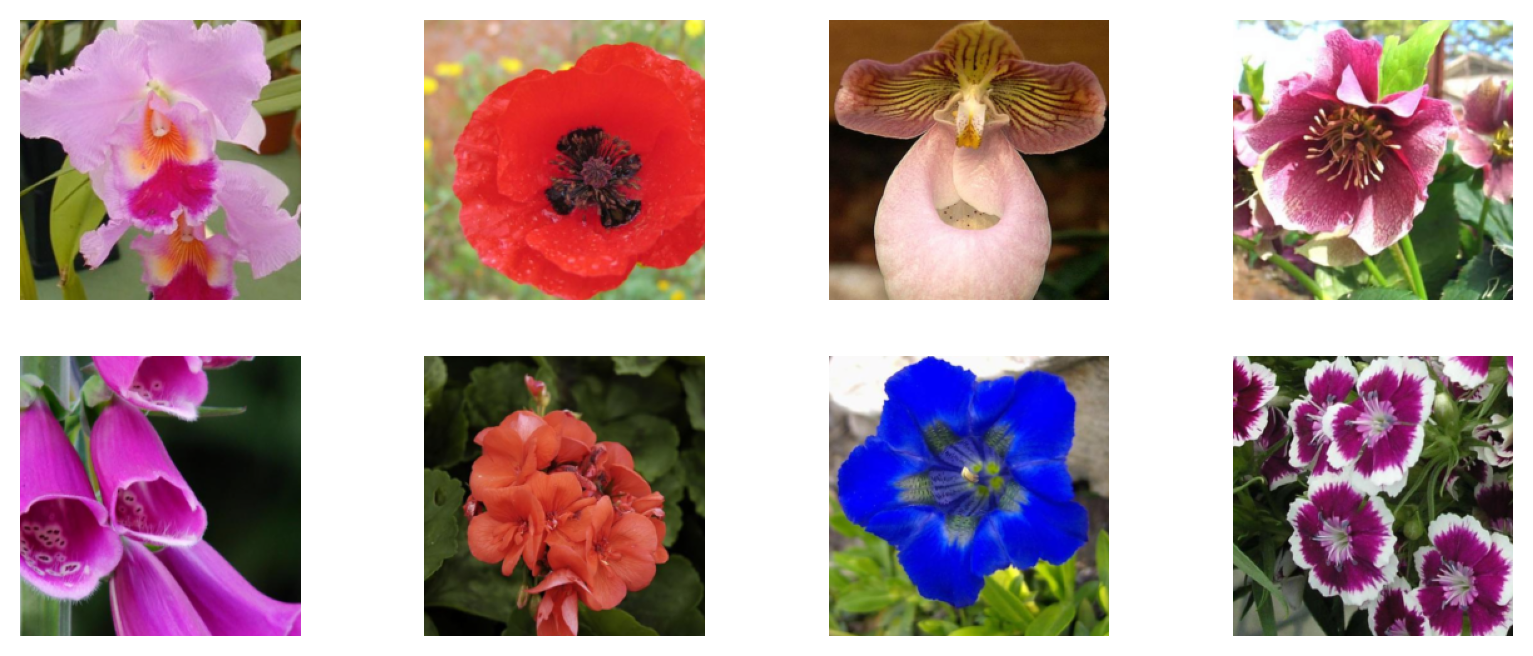

In [24]:
show_image(images,7)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

In [25]:
def predict(processed_image, model, topk=5,device='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    tensor = torch.from_numpy(np.expand_dims(processed_image, axis=0))

    model.eval()
    with torch.no_grad():
        outputs = model(tensor.float())

    ps = torch.exp(outputs)
    probs, ind = ps.topk(topk)

    classes = [i +1  for i in ind[0].tolist()]

    return probs[0].tolist(), classes

In [26]:
probs, classes = predict(images[0,:,:,:],model)

In [27]:
print(probs)
print(classes)

[0.8923965692520142, 0.05141577869653702, 0.025604190304875374, 0.012048039585351944, 0.0037457195576280355]
[36, 43, 68, 98, 72]


We can write another function that will display the original image, together with the top 5 most probable classes

In [36]:
def plot_class_probs(processed_image,label, model):

    mean = np.array(means)
    std = np.array(stdevs)

    probs, classes = predict(processed_image,model)

    names_of_plants = [cat_to_name[str(i)] for i in classes]
    correct_name = cat_to_name[str(label+1)]

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
    ax1.axis('off')
    ax1.set_title(correct_name)

    image = processed_image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax1.imshow(image)

    plt.barh(y=names_of_plants,width=probs)


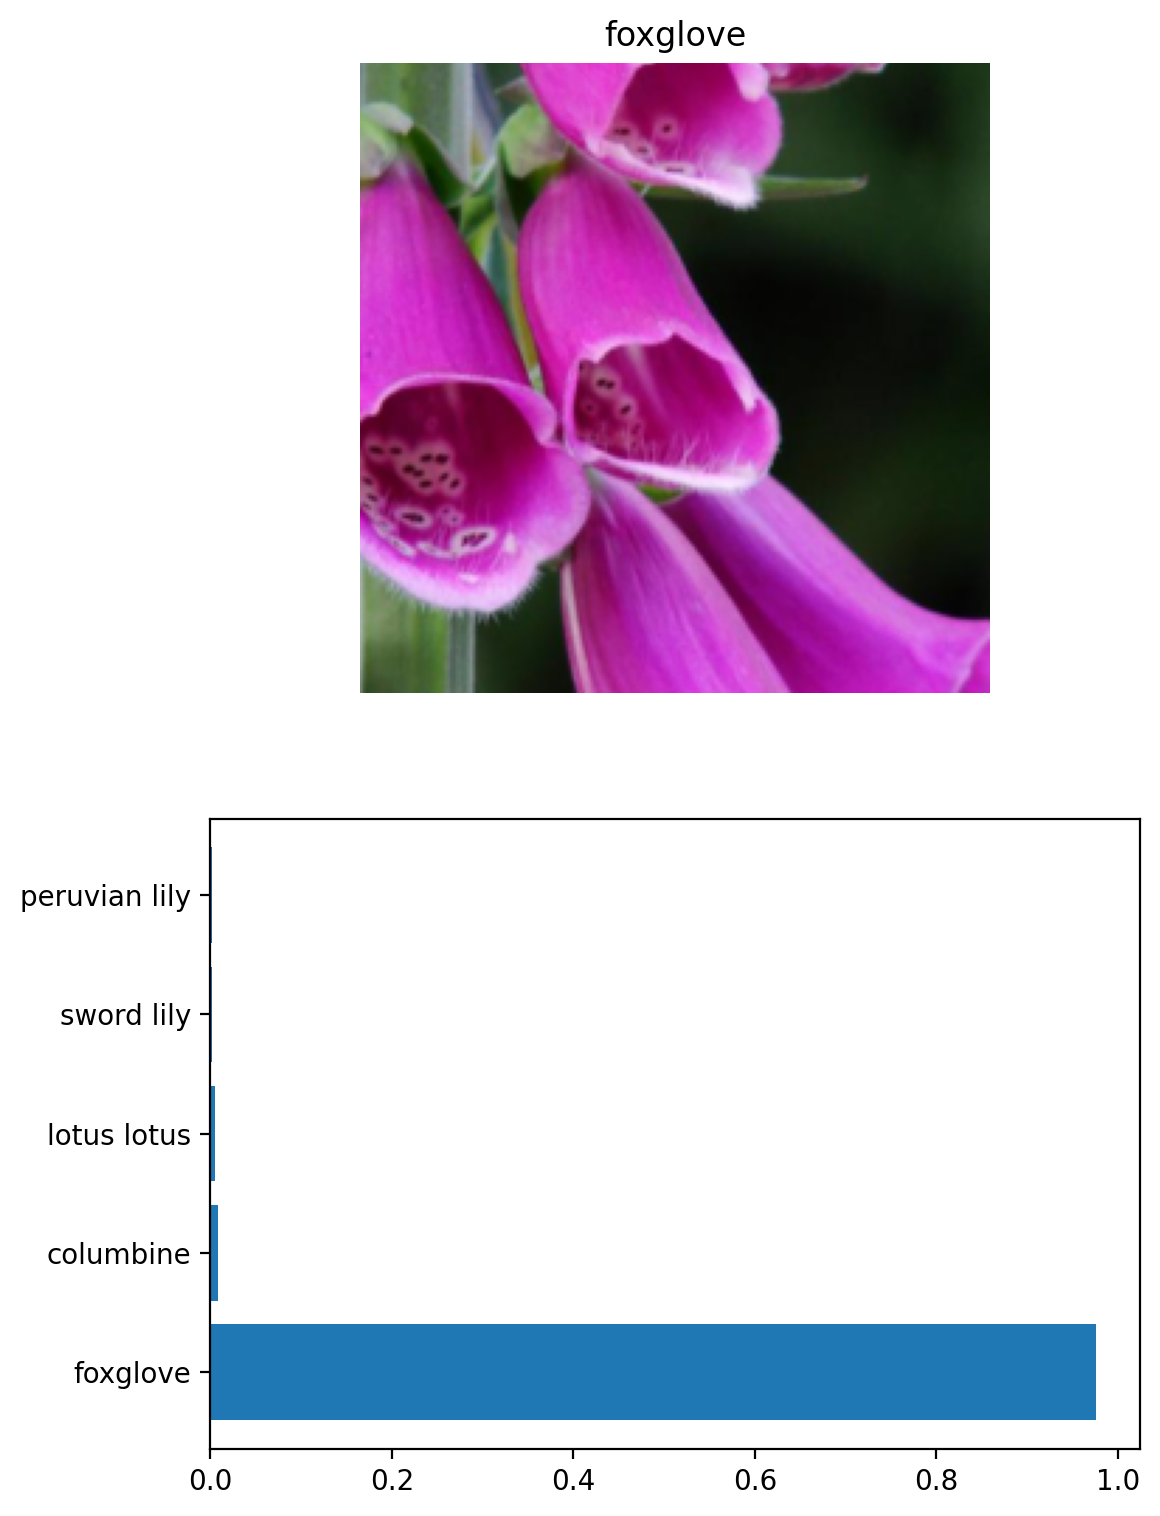

In [41]:
plot_class_probs(images[0,:,:,:],labels[0].numpy(), model)